# PROJECT: Course Optimization for Data Science
## Optimization strategies for (Rank-)Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Robert Gower

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs for binary classification with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the "without intercept" case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- use these solvers to tackle the SVM-rank ML problem
- present a clear benchmark of the different strategies on small and medium scale datasets
- test your code on real data!


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 17th of January 2021 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "joel"
ln1 = "garde"
fn2 = "mathieu"
ln2 = "juttet"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_garde_joel_and_juttet_mathieu.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
from numba import jit, njit

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install -c conda-forge cvxopt`

(if you're using conda)

or

`pip install cvxopt`

See https://cvxopt.org/install/ for instructions.

If you **struggle too much please contact us**. Don't waste time with this!

In [3]:
!pip install cvxopt

<div class="alert alert-info">
    <h2>Part 0: SVM Classification with linear kernel</h2>
</div>

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

The function $f(w, b) = \frac{1}{2} w^Tw $ is convex as a quadratic.

The constraints $c_i(w, b) =- (y_i(w^T x_i + b) - 1)$ are convex as a linear.

Therefore the problem $(\mathcal{P})$ is convex.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:</li>
    </ul>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

Remark: We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.
</div>

$$ \begin{align} 
\mathcal{L}(w, b, \mu) &= \frac{1}{2} w^Tw - \sum_{i=0}^n \mu_i (y_i (w^Tx_i +b) -1 )\\
&= \frac{1}{2} w^Tw - \sum_{i=0}^n \mu_i (y_i x_i^Tw  +y_ib -1 )\\
&= \frac{1}{2} w^Tw - \sum_{i=0}^n \mu_i (G_i w +y_ib -1 )\\
&= \frac{1}{2} w^Tw - \mu^T Gw - \mu^Tyb + \mu^Tu  
\end{align}$$

Stationnarity:
$$
\begin{align}
\nabla_{w}\mathcal{L} &= 0 \Leftrightarrow w^* =  G^T\mu \\
\nabla_{b}\mathcal{L} &= 0 \Leftrightarrow   y^T\mu = 0 
\end{align}$$

Dual feasability:
$$
- \mu \leq 0
$$

So 
$$
\mathcal{g}(\mu) = \frac{1}{2} {w^*}^Tw^* - \mu^TGw^* - 0 + \mu^Tu  \\
\mathcal{g}(\mu) = \frac{1}{2} \mu^TGG^T\mu - \mu^TGG^T\mu + \mu^Tu\\
\max_\mu \mathcal{g}(\mu) = \min_\mu \frac{1}{2} \mu^TGG^T\mu  -\mu^Tu\\
$$

we retrieve 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:</li>
    </ul>
    $$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$
</div>

$f(x) = \mathrm{sign}(w^Tx + b) $ where $w = G^T\mu$


$w_i = \sum_{j=1}^n G^T_{i,j} \mu_j$

$w_i = \sum_{j=1}^n G_{j,i}\mu_j$

$w_i = \sum_{j=1}^n y_j x_{i,j}\mu_j$

$w = \sum_{j=1}^n \mu_j y_j x_j $


so $ y = \mathrm{sign} (\sum_{i=0}^n \mu_iy_ix_i^Tx + b )$

<div class="alert alert-info">
    <h2>Part 1: Implementation of solver with intercept using cvxopt</h2>
</div>

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [4]:
from svm_project_utils import plot_dataset, datasets

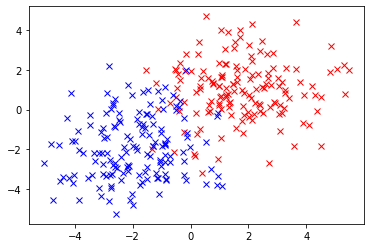

In [5]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

- We are dealing with the following problem:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

* So we have the following equivalences:

$$
\begin{align}
&x \leftrightarrow \mu \\
&e \leftrightarrow u\\
&H \leftrightarrow GG^T\\
&A \leftrightarrow y \\
&b \leftrightarrow 0 \\
&C \leftrightarrow + \inf \\
\end{align} 
$$

In [6]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [7]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
       <li>Modify the following cell to solve the SVM dual problem:</li>
    </ul>
</div>

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

Number of support vectors: 3


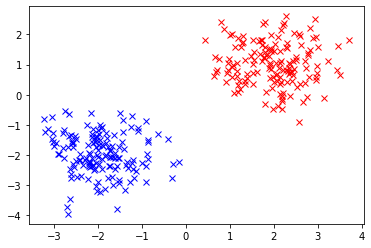

In [8]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def svm_solver(K, y, C=np.inf):
    y = y.reshape((-1,1))
    H = y @ y.T * K  #note that it would be easier to do kernel(X * y, X * y)
    e = np.ones_like(y)
    A = y 
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Compute w from mu and b</li>
    </ul>
</div>

In [9]:
# TODO
w = (X[idx_support] * (y[idx_support].reshape((-1,1)))).T @ mu_support

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Using complementary slackness, explain how to obtain $b$ from $\mu$.</li>
    </ul>
<br/>
    <b>Remark:</b> complementary slackness states that if $\mu_i$ is an optimal lagrange multiplier and $f_i$ is a constraint of the primal problem than $\mu_i f_i(x^*) = 0$, where x^* is here a primal optimal value (notations here do not match the SVM context).
<br/><br/>
    <b>HINT:</b> Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.
<br/><br/>
    <b>HINT:</b> Have a look at <a href="https://web.stanford.edu/class/ee364a/lectures/duality.pdf">these slides</a> and chapter 5 in <a href="https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf"> this book </a> for more information on convex duality.
</div>

$(w^{t}x_{i}+b) = 1 \Leftrightarrow \\ b = \frac{1}{y_i} - w^T x_i \\
b = y_i - w^T x_i \qquad \forall i \;\text{where}\; \mu_i \neq0\\
b = y_i - \sum_{j=1}^n( \mu_j y_j  x_i^T x_j) \qquad \forall i \;\text{where}\; \mu_i \neq0\\
b = y_i - \sum_{j=1}^n( \mu_j y_j  K[i,j]) \qquad \forall i \;\text{where}\; \mu_i \neq0\\
b = (y_{support} - K_{\text{support}} (\mu_\text{support} \odot y_{\text{support}}))_i \\\\
$

In [10]:
# TODO
def compute_b(K, y, mu_support, idx_support):
    # TODO
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    b = y_support - K_support @ (mu_support * y_support)  #true forall i
    return b.mean() #mean to smooth computationnal inaccuracy

b = compute_b(K, y, mu_support, idx_support)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
       <li>Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:</li>
    </ul>
$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.
</div>

In [11]:
e = 1e-5
(y * (X @ w + b) > 1 - e).all()

True

Check your code by running the following cell:

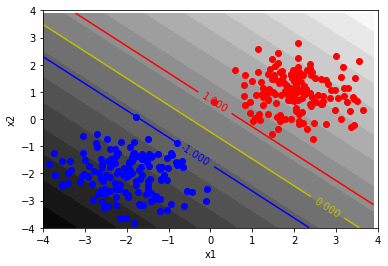

In [43]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel, lim=4):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-lim:lim:0.1, -lim:lim:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], colors=['b', 'y', 'r'])
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-lim, lim])
    plt.ylim([-lim, lim])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearly separable anymore.

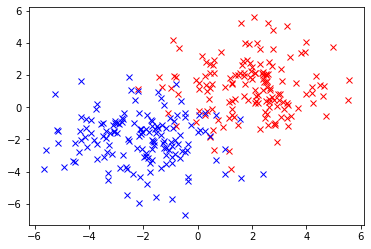

In [13]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [14]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
       <li>Check that constraints of the problem are now violated, can you explain what happened? How many are there according to the precision given in Question 7?</li>
    </ul>
</div>

All the primal constraints are violated at the given precision. 

We expected the solver to gove the best possible separation and to have the minimal number of violated constraints corresponding to the points on the wrong side of the hyperplan. Instead, the decision surface below is surprizing. It seems that the solver could not handle the non-separable case.  

False

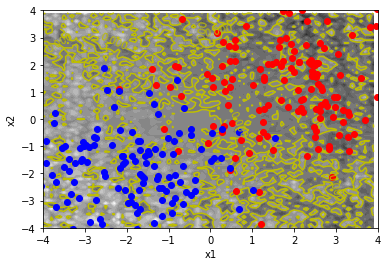

In [15]:
plot_classif(X, y, mu_support, idx_support, b, kernel=kernel)
#Is there any non-violated?
(y * (X @ w + b) > 1 - e).any()

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
         <li>Justify that $(P_{s})$ is a convex problem.</li>
         <li>Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div>

* Functions and constraints are convex.

* $(P_S)$:
$$ \begin{align} 
\mathcal{L}(w, b, \mu, \xi, \gamma) &= \frac{1}{2} w^Tw - \sum_{i=0}^n \mu_i (y_i (w^Tx_i +b) -1 + \xi_i) + C\sum_i\xi_i
- \sum_{i=1}^n \gamma_i \xi_i\\
&= \frac{1}{2} w^Tw - \mu^TGw - \mu^Tyb + \mu^T(u-\xi) + C \xi^T u - \gamma^T \xi\\
\end{align}$$

Stationnarity:
$$
\begin{align}
\nabla_{w}\mathcal{L} &= 0 \Leftrightarrow w^* =  G^T\mu \\
\nabla_{b}\mathcal{L} &= 0 \Leftrightarrow   y^T\mu = 0 \\
\nabla_{\xi}\mathcal{L} &= 0 \Leftrightarrow - \mu + C u - \gamma = 0 \Leftrightarrow \gamma = C u - \mu
\end{align}$$

Dual feasability:
$$
- \mu \leq 0 \\
- \gamma \leq 0 \Leftrightarrow \mu - C u \leq 0 \\
0 \leq \mu \leq C u
$$

So 
$$
\mathcal{g}(\mu) = \frac{1}{2} {w^*}^Tw^* - \mu^TGw^* - 0 + \mu^T u - \mu^T\xi + C\xi^T u - C u\xi^T + \mu \xi^T\\
\mathcal{g}(\mu) = \frac{1}{2} \mu^TGG^T\mu - \mu^TGG^T\mu + \mu^T u\\
\max_\mu \mathcal{g}(\mu) = \min_\mu \frac{1}{2} \mu^TGG^T\mu  -\mu^Tu\\
$$

we retrieve 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& 0 \leq \mu \leq C
 \end{array}
 \right .
$$

with $u=1_n$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
       <li>Modify your code from Question 4 to handle the non-separable case.</li>
    </ul>
</div>

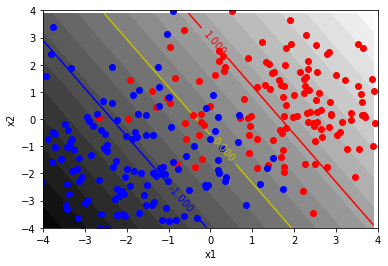

In [16]:
# TODO

X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=0.01)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
       <li>What is the influence of C on the number of support vectors? Make a plot that demonstrates this empirically.</li>
    </ul>
</div>

Logically, the bigger C is, the more penalty there is to make the margin bigger: the number of support vectors is inversely proportional to C.

In [17]:
# TODO
C = np.logspace(-4, 1)
n_support = [ len(svm_solver(K, y, C=c)[1]) for c in C ] 

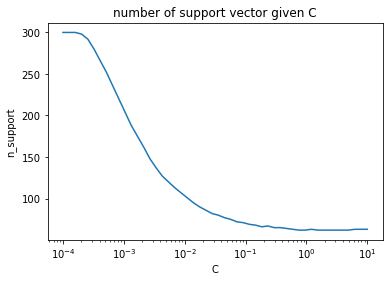

In [18]:
plt.semilogx(C, n_support)
plt.title("number of support vector given C")
plt.xlabel("C")
plt.ylabel("n_support")
plt.show()

We indeed have a decreasing number of support vectors with C, untim wer reach a minimal number around 50 for this problem (while we found 3 in the separable case). These are the points inside the margins, therefore even if it does not exactly represent the number of "intermingeled" points of our problem, it allows us to bound it.

<div class="alert alert-info">
    <h2>Part 3: non-linear case with kernels</h2>
</div>

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
     <ul>
       <li>Denoting by $K(x_i, x_j)$ the dot product between samples, show that dual problem and the decision function f(x) can be reformulated just using calls to $K$</li>
    </ul>
</div> 

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

$X$ appears only in $GG^T$, which is a function of $y$ and $K(X,X)$ :  the dual problem is a function of K and  y,
you can even call it with K(yX, yX)

the decision for $x_{test}$ is given by so $ y_{test} = \mathrm{sign} (\sum_{i=0}^n \mu_i y_i x_i ^T x_test + b )$
$y_{test} = \mathrm{sign} (\sum_{i=0}^n \mu_i y_i K(x_i, x_{test}) + b ) $

So the decision function can also be expressed with K only.

We will use the clowns dataset to evaluate this:

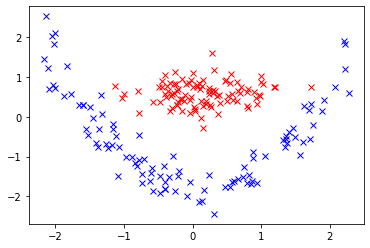

In [19]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

<div class="alert alert-success">
    <b>QUESTION 13:</b>
     <ul>
       <li>Update your kernel function so it computes the Gaussian kernel:</li>
    </ul>
    $$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
$$

where $\gamma > 0$ is the kernel bandwidth.
</div> 

In [20]:
# TODO
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    gamma = 3.
    D = gamma * ( (X1**2).sum(axis=1)[...,None] + (X2**2).sum(axis=1)[...,None].T - 2 * X1 @ X2.T)
    K = np.exp( - D )
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

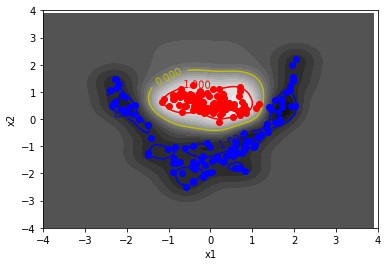

In [21]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

<div class="alert alert-info">
    <h2>Part 4: Linear SVM without intercept</h2>
</div>

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^\top \mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 14:</b>
     <ul>
       <li>Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div> 

$$ \begin{align} 
\mathcal{L}(w, \mu, \xi, \gamma) &= \frac{1}{2} w^Tw - \sum_{i=0}^n \mu_i (y_i (w^Tx_i) -1 + \xi_i) + C\sum_i\xi_i
- \sum_{i=1}^n \gamma_i \xi_i\\
&= \frac{1}{2} w^Tw - \mu^T G w  + \mu^T(u-\xi) + C \xi^Tu - \gamma^T \xi\\
\end{align}$$

Stationnarity:
$$
\begin{align}
\nabla_{w}\mathcal{L} &= 0 \Leftrightarrow w^* =  G^T\mu \\
\nabla_{\xi}\mathcal{L} &= 0 \Leftrightarrow - \mu + C u - \gamma = 0 \Leftrightarrow \gamma = C u - \mu
\end{align}$$

Dual feasability:
$$
- \mu \leq 0 \\
- \gamma \leq 0 \Leftrightarrow \mu - C u \leq 0 \\
0 \leq \mu \leq C u
$$

So 
$$
\mathcal{g}(\mu) = \frac{1}{2} {w^*}^Tw^* - \mu^TGw^* + \mu^T u - \mu^T\xi + C\xi^T u - \xi^T C u + \xi^T \mu \\
\mathcal{g}(\mu) = \frac{1}{2} \mu^TGG^T\mu - \mu^TGG^T\mu + \mu^T u\\
\max_\mu \mathcal{g}(\mu) = \min_\mu \frac{1}{2} \mu^TGG^T\mu  -\mu^Tu\\
$$

we retrieve 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{T}\mu-\mu^{\top}u
 \\
 \mathrm{and}& 0 \leq \mu \leq C
 \end{array}
 \right .
$$

with $u=1_n$

<div class="alert alert-success">
    <b>QUESTION 15:</b>
     <ul>
       <li>Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$
         </li>
    </ul>
</div>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{and}& 0 \leq \mu \leq C
 \end{array}
 \right .
$$


$$(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu)$$

where $$f(\mu) = \frac{1}{2}\mu^{\top}GG^{T}\mu-\mu^{\top}u $$
$$g(\mu) = \mathbb{1}_{[0,C]^n}(\mu)$$
$$L = \sigma_{max} (G)^2$$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 16:</b>
     Implement:
     <ul>
       <li>your own version of proximal gradient with and without acceleration</li>
       <li>your own version of coordinate descent</li>
       <li>an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
    Test your implementations on the Gaussian blobs and evaluate the performance
    of your implementations in terms of computation time on problems where the matrix 
    $G G^\top$ can fit in memory. Give a short conclusion.
</div>

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is voluntary vague, but it is the most important and will constitute half of the final grade on the project ! We are waiting for beautiful plots, as well as sharp comments!**

In [22]:
@njit
def prox(x, C):
    return np.maximum(np.minimum(x, C), 0)

#wrapper to have the same interface for all algorithms and to be able to njit the core.
def grad_desc(C, X, y, n_iter, bias):
    X = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = X * y[...,None]
    Linv = np.linalg.norm(G, 2)**(-2)
    return grad_desc_(C, G, n_iter, Linv)

@njit
def grad_desc_(C, G, n_iter, Linv):
    """classic gradient descent.
    returns mu (support vectors), w (wheights), mu_list: all the mu during the descent.
    """
    mu = np.zeros((G.shape[0]))
    mu_list = []
    u = np.ones_like(mu)
    
    for t in range(n_iter):
        w = G.T @ mu #to do optimize to G.T mu since a lot are 0 or C
        grad = G @ w - u
        mu = prox(mu - Linv * grad, C )
        mu_list.append(mu.copy())
    return mu, (G.T @ mu), mu_list

#wrapper to have the same interface for all algorithms and to be able to njit the core.
def acc_grad_desc(C, X, y, n_iter, bias):
    X = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = X * y[...,None]
    Linv = np.linalg.norm(G, 2)**(-2)
    return acc_grad_desc_(C, G, n_iter, Linv)

@njit
def acc_grad_desc_(C, G, n_iter, Linv):
    """accelerated gradient descent.
    returns mu (support vectors), w (wheights), mu_list: all the mu during the descent.
    """
    mu = np.zeros((G.shape[0]))
    mu_list = []
    u = np.ones_like(mu)
    mom = np.zeros_like(mu)
    beta = 1 
    
    for t in range(n_iter):
        w = G.T @ mu #to do optimize to G.T mu since a lot are 0 or C
        grad = G @ w - u
        mom_new = prox(mu - Linv * grad, C )
        beta_new = 0.5 * (1 + np.sqrt(1 + 4 * beta**2))
        mu = mom_new + (beta - 1) / beta_new * (mom_new - mom)
        mom = mom_new
        beta = beta_new
        mu_list.append(mu.copy())
    return mu, (G.T @ mu), mu_list

#wrapper to have the same interface for all algorithms and to be able to njit the core.
def cord_desc(C, X, y, n_iter, bias):
    X = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = X * y[...,None]
    Linv = np.linalg.norm(G, axis=1)**(-2)
    return cord_desc_(C, G, n_iter, Linv)

@njit
def cord_desc_(C, G, n_iter, Linv):
    """coordinate gradient descent (non-greedy version)
    returns mu (support vectors), w (wheights), mu_list: all the mu during the descent.
    """
    mu = np.zeros((G.shape[0]))
    mu_list = []
    w = G.T @ mu #residual: trick to be fast
    
    for t in range(n_iter * mu.shape[0]):
        i = t % mu.shape[0]
        
        if i== 0:
            mu_list.append(mu.copy())
        #mu_list.append(mu.copy())
        grad = np.dot(G[i], w) - 1
        mu_prev = mu[i]
        mu[i] = prox(mu[i] - Linv[i] * grad, C)
        w += (mu[i] - mu_prev) * G[i] #trick to be fast

    return mu, w, mu_list

# TODO
from scipy.optimize import fmin_l_bfgs_b

#wrapper to have the same interface for all algorithms and to be able to njit the core.
def l_bfgs_b(C, X, y, n_iter, bias):
    """LBFGS-B wrapper
    returns x[-1] (support vectors), w (wheights), mu_list: all the mu during the descent.
    """
    X = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = X * y[...,None]
    Linv = np.linalg.norm(G, 2)**(-2)
    mu = np.zeros((G.shape[0]))
    mu_list = []
    u = np.ones_like(mu)
    
    def func(x):
        return 0.5 * np.dot(x, G @ (G.T @ x)) - np.dot(u, x)
    
    def fprime(x):
        return G @ (G.T @ x) - u
    
    def save_progress_callback(x):
        mu_list.append(x.copy())
    
    bounds = [(0, C)] * mu.shape[0]
    factr=10.0 #choose factr to have high precision
    x, f, d = fmin_l_bfgs_b(func, mu,factr=factr,maxiter=n_iter, fprime=fprime, bounds=bounds, callback=save_progress_callback)
    return x, G.T @ x, mu_list

### running the optimizers

In [23]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.2)

In [24]:
mu_grad, w_grad, mul_grad = grad_desc(0.1, X, y, 5000, 1)

In [25]:
mu_acc, w_acc, mul_acc = acc_grad_desc(0.1, X, y, 5000, 1)

In [26]:
mu_lbfgsb, w_lbfgsb, mul_lbfgsb = l_bfgs_b(0.1, X, y, 5000, 1)

In [27]:
mu_cd, w_cd, mul_cd = cord_desc(0.1, X, y, 50, 1)

In [28]:
print(f"cd converged ok: {np.allclose(w_lbfgsb, w_cd, rtol=1e-4)}")
print(f"acc converged ok: {np.allclose(w_lbfgsb, w_acc, rtol=1e-4)}")
print(f"grad converged ok: {np.allclose(w_lbfgsb, w_grad, rtol=1e-4)}")

cd converged ok: True
acc converged ok: True
grad converged ok: False


all our optimizers converged to the same point expect for the classic gradient descent, including the lfbgs-b that we did not implement, this is good news. We will see after that the classic gradient descent did not have enought time to converge.

In [29]:
def objective(x, G):
    u = np.ones_like(x)
    return 0.5 * np.dot(x, G @ (G.T @ x)) - np.dot(u, x)

def plot_convergence(best=mu_lbfgsb, bias=1):
    
    fig, axes = plt.subplots(2, 2, figsize=(12,12))
    
    Xstack = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = Xstack * y[...,None]
    all_lists = [(mul_grad, "gradient"), (mul_acc, "accelerated"), (mul_cd, "coordinate"), (mul_lbfgsb, "lbfgs-b")]
    
    for ax, (mu_list, label) in zip(axes.ravel(), all_lists):

        objs = np.array([objective(mu, G) for mu in mu_list])
        eps = np.finfo('float').eps
        ax.semilogy(np.maximum(np.abs(objs - objective(best, G)), eps), label=label)
        plt.suptitle("convergence")
        ax.set_ylabel("objective value")
        ax.set_xlabel("epoch")
        ax.legend()
        ax.set_title(label)
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    for (mu_list, label) in all_lists:
        objs = np.array([objective(mu, G) for mu in mu_list])
        eps = np.finfo('float').eps
        ax.loglog(np.maximum(np.abs(objs - objective(best, G)), eps), label=label)
        plt.suptitle("convergence")
        plt.ylabel("objective value")
        plt.xlabel("epoch")
        plt.legend()
        plt.title("comparing convergences")

    plt.show()
    

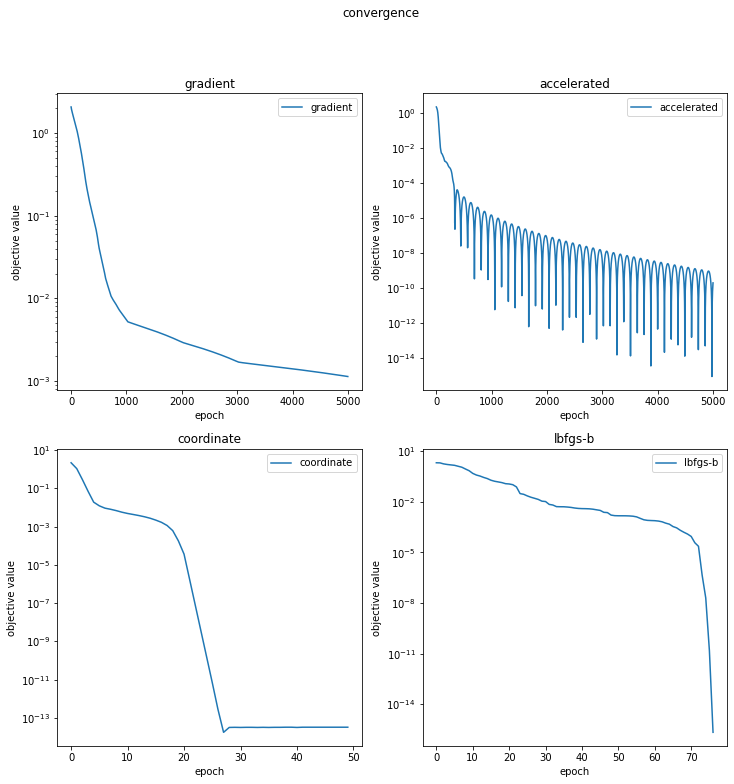

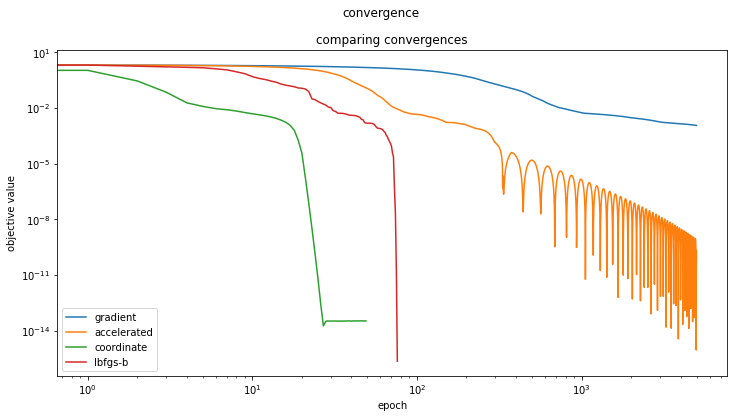

In [30]:
plot_convergence()

Unsurprinsingly, classic gradient descent is the slowest to converge with a linear rate, then accelerated gradient descent with a squared rate, which also presents the ripples due to momentum.
Then lbfgs-b converges in approximately 90 epochs, and coordinate descent in only 30 epochs !
That can be explained: if there are few support vectors, the full zero start of the coordinate descent is already a good point, it it has only to update to few support vectors that will be non-zero.

Lbfgs-b is expected to be fast, since we are working on a quadratic + linear term, which should not be so far from the quadratic that in the perfect theorical case is solved in n_features iterations since we are in the dual problem.

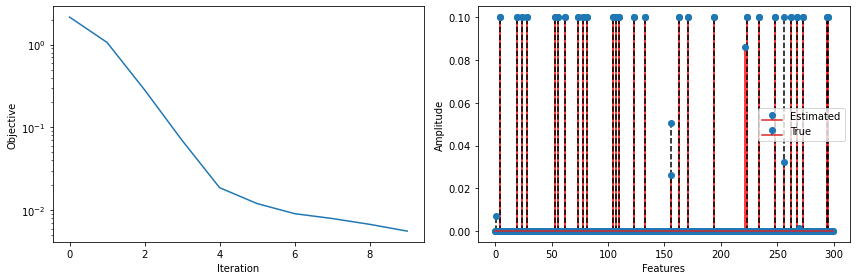

In [31]:
def plot_stem(optimizer, n_iter):
    best = mu_lbfgsb
    mu, w, mu_list = optimizer(0.1, X, y, n_iter, 1)
    bias = 1
    Xstack = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = Xstack * y[...,None]
    objs = np.array([objective(mu, G) for mu in mu_list])

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax1.semilogy(objs -objective(best, G))
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Objective')
    ax2.stem(mu, linefmt='r-', label='Estimated',)
    ax2.stem(best, linefmt='k--', label='True',)

    ax2.set_xlabel('Features')
    ax2.set_ylabel('Amplitude')
    plt.legend()
    plt.tight_layout();


plot_stem(cord_desc, n_iter=10)

In [32]:
from ipywidgets import interact, fixed
opt_list = [grad_desc, acc_grad_desc, cord_desc, l_bfgs_b]
interact(plot_stem, optimizer = opt_list, n_iter=(0, 5000, 1))

interactive(children=(Dropdown(description='optimizer', options=(<function grad_desc at 0x7fb3b74b1560>, <func…

<function __main__.plot_stem(optimizer, n_iter)>

By plotting the stem of the support vectors, we understand why coordinate descent was the fastest to converge: it is the faster to correctly identify the support vectors and optimizing them. 

In [33]:
def objective(x, G):
    u = np.ones_like(x)
    return 0.5 * np.dot(x, G @ (G.T @ x)) - np.dot(u, x)

def plot_interact(sigma, C, bias=1):
    X, y = datasets(name='gaussian', n_points=300, sigma=sigma)
    mu_grad, w_grad, mul_grad = grad_desc(C, X, y, 1000, 1)
    mu_acc, w_acc, mul_acc = acc_grad_desc(C, X, y, 1000, 1)
    mu_lbfgsb, w_lbfgsb, mul_lbfgsb = l_bfgs_b(C, X, y, 1000, 1)
    mu_cd, w_cd, mul_cd = cord_desc(C, X, y, 1000, 1)
    best = mu_lbfgsb
    
    Xstack = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = Xstack * y[...,None]
    all_lists = [(mul_grad, "gradient"), (mul_acc, "accelerated"), (mul_cd, "coordinate"), (mul_lbfgsb, "lbfgs-b")]
    
    fig, (ax1,ax2)  = plt.subplots(1, 2, figsize=(20,6))
    
    for (mu_list, label) in all_lists:
        objs = np.array([objective(mu, G) for mu in mu_list])
        eps = np.finfo('float').eps
        ax1.loglog(np.maximum(np.abs(objs - objective(best, G)), eps), label=label)
        ax1.set_title("convergence")
        ax1.set_ylabel("objective value")
        ax1.set_xlabel("epoch")
        ax1.legend()
        ax1.set_title("comparing convergences")
        
    ax2.stem(best, linefmt='r-', label='lbfgs-b stem plot',)
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Amplitude')
    plt.legend()
    plt.tight_layout();

In [34]:
import ipywidgets as widgets

In [35]:
C = widgets.FloatLogSlider(
    value=0,
    base=10,
    min=-4, # max exponent of base
    max=1, # min exponent of base
    step=0.2, # exponent step
    description='C'
)
interact(plot_interact, sigma=[("superposed", 1.7), ("separable", 0.4)], C=C, bias=fixed(1))

interactive(children=(Dropdown(description='sigma', options=(('superposed', 1.7), ('separable', 0.4)), value=1…

<function __main__.plot_interact(sigma, C, bias=1)>

As C augment, the number of support vectors goes down. And the convergence for all algorithms is delayed. 
This is a bit unexpected for the coordinate decente, as I would have expected that is is faster if there is fewer support vector to optimize. Since it tries to optimize all of the vectors in each epoch, this might not be so surprising: we are still computing the optimization for all, wether they are support vector or not.

In [102]:
sigma = 0.5
X, y = datasets(name='gaussian', n_points=300, sigma=sigma)
X += 2

def plot_margin(C, bias):
    # We only look at the results of the coordinate descent.
    mu_cd, w_cd, mul_cd = cord_desc(C, X, y, 1000, bias)
    # We split the values of mu to get back the bias
    mu, mu_bias = mu_cd[:-2], mu_cd[-1]
    
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    b = w_cd[-1]*bias
    plt.title(f'w_1:{w_cd[0]:.2f}, w_2:{w_cd[1]:.2f}, bias:{b:.3f}')
    plot_classif(X, y, mu_support, idx_support, b,  lim=7)
    # "True" value with the other solver
    K = kernel(X, X)
    mu_support, idx_support = svm_solver(K, y, C=C)
    b_true = compute_b(K, y, mu_support, idx_support)
    print(f'dual_value={b:.3f}, "true_value"={b_true:.3f}')

In [103]:
bias = widgets.FloatLogSlider(
    value=0,
    base=10,
    min=-2, # max exponent of base
    max=3, # min exponent of base
    step=0.2, # exponent step
    description='const_feat_value'
)

interact(plot_margin, C=fixed(0.3), bias=bias)

interactive(children=(FloatLogSlider(value=0.01, description='const_feat_value', max=3.0, min=-2.0, step=0.2),…

<function __main__.plot_margin(C, bias)>

This last plot shows how the margin evolves when affecting the constant feature. Our goal was to characterize the impact of an increasing constant feature on the bias. Indeed, since this feature is also regularized, we expected the regularization to prevent the bias from getting too large. However, we also expected that a larger constant feature would have induced a larger bias even if the regularization is strong. The interactive graph we obtain above is confirming our intuition as the bias is incrasing with the constant features (for const_feat_const=20 we have the closest value to the true_bias). However, if the constant feature is set too high, it seems to produce garbage values.

<div class="alert alert-info">
    <h2>Part 5: SVM Rank</h2>
</div>

You will now use the code you have written above to answer the following question: given two samples $x_i$ and $x_j$ in $\mathbb{R}^p$, with corresping labels $y_i$ and $y_j$ in $\mathbb{R}$ (note that now labels can be any real number, it's not just binary). Can I predict if $y_i > y_j$ or the oppositve?

To take a concrete example, imaging you go to a liquor store to buy a bottle on wine and you hesitate between two bottles. The SVM Rank model below will tell you if the quality of the wine encoded in the target $y$ is better for the first bottle or the second one.

Let's formalize this a bit. We aim to estimate a linear function $f_{w}(x) = x^\top w$ that minimizes
the following risk:

$$
\mathcal{R}_f=\mathbb{E}
    \left[
    \ell(f_w(x_i) - f_w(x_j), \mathrm{sign}(y_i-y_j))
    \right]
$$

where the loss $\ell$ is the Hinge loss of the SVM binary classifical model you have seen above. Namely:
$
    \ell(z, t) = \max(1 - tz, 0)
$ . Note that we limit ourselves here to linear SVM.

This leads to the following regularized empirical risk minimization problem:

$$
\hat{w} = \mathrm{arg}\,\min_{w \in \mathbb{R}^p} \left( C \sum_{i,j} \ell((x_i - x_j)^\top w, \mathrm{sign}(y_i-y_j)) + \|w\|_2^2 \right),
$$


This part is inspired by the following works:

    - R. Herbrich, T. Graepel, and K. Obermayer. Large margin rank boundaries for ordinal regression. MIT Press, Cambridge, MA, 2000.

    - T. Joachims. Optimizing search engines using clickthrough data. In Proceedings of the eighth ACM SIGKDD international conference on Knowledge discovery and data mining, pages 133–142, New York, NY, USA, 2002. ACM. 2
    
The following cell implements the `transform_pairwise` function. Given `X` and `y` this function builds all the pairs of samples to output a new dataset that corresponds to a binary classification problem. It basically outputs the differences between feature vectors and the sign of the difference of the targets.

In [76]:
import itertools


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking

    Transforms a n-class ranking problem into a two-class classification
    problem.

    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        Target labels.

    Returns
    -------
    X_trans : array, shape (n_pairs, n_features)
        Data formed by difference of feature vectors.
    y_trans : array, shape (n_pairs,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    comb = itertools.combinations(range(X.shape[0]), 2)
    k = 0
    for (i, j) in comb:
        if y[i] == y[j]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i] - y[j]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
        k += 1
    return np.array(X_new), np.array(y_new)

<div class="alert alert-success">
    <b>QUESTION 17:</b>
     The following cell implements a scikit-learn estimator for the SVM Rank
     model. It uses the liblinear solver shipped with scikit-learn.
     <ul>
       <li>Update the following code to use a solver developed above instead of scikit-learn LinearSVC estimator.
         You will justify this choice of solver in terms of performance
         based your experiments above.</li>
       <li>Run your updated estimator on the Wine quality dataset
         and compare the performance of your model with the liblinear
         solver. You will compare in terms of prediction score
         and in terms of computation time.</li>
    </ul>
</div>

**Note:** For the scorer we use here the [Kendall's rank correlation](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

$$
    \tau ={\frac {2}{n(n-1)}}\sum _{i<j}\operatorname {sgn}(x_{i}-x_{j})\operatorname {sgn}(y_{i}-y_{j})
$$

implemented in `scipy.stats.kendalltau`.

In [78]:
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, RegressorMixin


class RankSVM(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        self
        """
        self.svc_ = svm.LinearSVC(loss='hinge', dual=True, tol=1e-2,
            fit_intercept=True, C=self.C, max_iter=1000000)
        X_trans, y_trans = transform_pairwise(X, y)
        self.svc_.fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns an array of integers representing the relative order of
            the rows in X.
        """
        return np.argsort(np.dot(X, self.svc_.coef_.T).ravel())

    def score(self, X, y):
        """Score using Kendall rank correlation
        
        https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        score : float
            Kendall Tau rank correlation. Higher is better.
        """
        return stats.kendalltau(self.predict(X), y)[0]

In [111]:
# We adapt our coordinate descent to have it stopped as soon as it is converged.

def cord_desc_a(C, X, y, n_iter, bias, toll):
    X = np.hstack((X, bias * np.ones((X.shape[0], 1))))
    G = X * y[...,None]
    Linv = np.linalg.norm(G, axis=1)**(-2)
    return cord_desc_a_(C, G, n_iter, Linv, toll)

@njit
def cord_desc_a_(C, G, n_iter, Linv, toll):
    """coordinate gradient descent (non-greedy version)
    returns mu (support vectors), w (wheights), mu_list: all the mu during the descent.
    """
    mu = np.zeros((G.shape[0]))
    w = G.T @ mu #residual: trick to be fast
    w_old = w + 10

    for t in range(n_iter * mu.shape[0]):
        i = t % mu.shape[0]
        if i==0:
            diff = np.dot(w_old-w, w_old-w)
            if diff < toll**2:
                return mu, w
            else:
                w_old=w
        #mu_list.append(mu.copy())
        grad = np.dot(G[i], w) - 1
        mu_prev = mu[i]
        mu[i] = prox(mu[i] - Linv[i] * grad, C)
        w += (mu[i] - mu_prev) * G[i] #trick to be fast

    return mu, w

class RankSVM_cd(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """    
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        self
        
        """ 
        X_trans, y_trans = transform_pairwise(X, y)
        self.mu, self.w = cord_desc_a(self.C, X_trans, y_trans, 1000, 1.0, toll=1e(-7))
        self.coef_ = self.w[:-1]
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns an array of integers representing the relative order of
            the rows in X.
        """
        return np.argsort(np.dot(X, self.coef_)).ravel()

    def score(self, X, y):
        """Score using Kendall rank correlation
        
        https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        score : float
            Kendall Tau rank correlation. Higher is better.
        """
        return stats.kendalltau(self.predict(X), y)[0]

SyntaxError: invalid syntax (<ipython-input-111-6994f98ef49f>, line 58)

In [108]:
class RankSVM_lbfgsb(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        self
        
        """ 
        X_trans, y_trans = transform_pairwise(X, y)
        self.mu, self.w, _ = l_bfgs_b(self.C, X_trans, y_trans, 1000, 1.0)
        self.coef_ = self.w[:-1]
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns an array of integers representing the relative order of
            the rows in X.
        """
        return np.argsort(np.dot(X, self.coef_)).ravel()

    def score(self, X, y):
        """Score using Kendall rank correlation
        
        https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        score : float
            Kendall Tau rank correlation. Higher is better.
        """
        return stats.kendalltau(self.predict(X), y)[0]

In [80]:
# Loading the data
import pandas as pd
from sklearn.model_selection import cross_val_score

df = pd.read_csv('winequality-red.csv', delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [81]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df_small = df[::2]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values

y = df_small.quality.values
clf = make_pipeline(StandardScaler(), RankSVM(C=1.))
scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())

Average Kendall Rank Correlation: 0.08
CPU times: user 23.5 s, sys: 588 ms, total: 24.1 s
Wall time: 29.7 s


In [113]:
%%time

df_small = df[::2]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values

y = df_small.quality.values
clf = make_pipeline(StandardScaler(), RankSVM_cd(C=1.))
scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())

Average Kendall Rank Correlation: 0.09
CPU times: user 1.95 s, sys: 77.3 ms, total: 2.03 s
Wall time: 1.88 s


In [98]:
%%time

df_small = df[::2]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values

y = df_small.quality.values
clf = make_pipeline(StandardScaler(), RankSVM_lbfgsb(C=1.))
scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())

Average Kendall Rank Correlation: 0.06
CPU times: user 1min 48s, sys: 3.37 s, total: 1min 51s
Wall time: 1min 25s


We ran our coord_desc and our L-BFGS-B as they were our two best algorithms. We used a modified version of our coordinate descent where we stop as soon as the norm of the coefficients has converged up to tolerance. We also remove the logging of past iterations to accelerate our algorithm. With such an algorithm, we reach a better Kendall Rank than the refenrence RankSVM (0.09 instead of 0.08) in a way faster delay (1.88s instead of 29.7s).